# The full python workflow for semasiological token-level clouds 

This notebook shows the full workflow followed to create the clouds in Chapter 5 of the monograph (and my dissertation).

(Eventually, add Kris's chapter too)

For this purpose I'm creating a Python package with more order than my previous attempts. It is called `semasioFlow` and has the most verbose code; its documentation can be explored [here](docs/build/html/index.html).

## 0. Initial setup 

So first we have to add this directory to the path in order to import `semasioFlow`. When it initializes, it loads other libraries we need as well as the `qlvl` library from the `depmodel` repository.

In [1]:
import os
import sys
import logging
sys.path.append("/home/aardvark/code/nephosem")
mypackage = "/home/projects/semmetrix/mariana_wolken/cleanWorkflow/scripts/"
sys.path.append(mypackage)

In [2]:
from semasioFlow import ConfigLoader
from semasioFlow.load import loadVocab, loadMacro, loadColloc, loadFocRegisters
from semasioFlow.sample import sampleTypes
from semasioFlow.focmodels import createBow, createRel, createPath
from semasioFlow.socmodels import targetPPMI, weightTokens, createSoc
from semasioFlow.utils import plotPatterns

## 1. Configuration 

Depending on what you need, you will have to set up some useful paths settings.
I like to have at least the path to my project (`mydir`), an output path within (`mydir + "output"`) and a GitHub path for the datasets that I will use in the visualization. There is no real reason not to have everything together, except that I did not think of it at the moment. (Actually, there is: the GitHub stuff will be public and huge data would not be included. How much do we want to have public?)

In [4]:
mydir = "/home/projects/semmetrix/mariana_wolken/cleanWorkflow/"
output_path = f"{mydir}/output/"
github_dir = f"{mydir}/github/"
logging.basicConfig(filename = f'{mydir}/testlog.log', level = logging.DEBUG)

The variables with paths is just meant to make it easier to manipulate filenames. The most important concrete step is to adapt the configuration file.

In [5]:
conf = ConfigLoader()
default_settings = conf.settings
settings = default_settings
# Regular expression to capture data from the QLVLNewsCorpus
settings['line-machine'] = '([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t([^\t]+)\t_\t_'
settings['separator-line-machine'] = "^</sentence>$"
settings['global-columns'] = "id,word,lemma,pos,head,deprel"
settings['note-attr'] = 'word,lemma,pos'
settings['edge-attr'] = 'deprel'
settings['currID'] = 'id'
settings['headID'] = 'head'
settings['type'] = 'lemma/pos'
settings['colloc'] = 'lemma/pos'
settings['token'] = 'lemma/pos/fid/lid'

settings['file-encoding'] = 'latin1'
settings['outfile-encoding'] = 'utf-8'
settings['output-path'] = output_path
settings['corpus-path'] = '/home/aardvark/corp/nl/'

print(settings['line-machine'])
print(settings['global-columns'])
print(settings['type'], settings['colloc'], settings['token'])

([^	]+)	([^	]+)	([^	]+)
word,pos,lemma
lemma/pos lemma/pos lemma/pos/fid/lid


## 2. Frequency lists

The frequency lists are the first thing to create, but once you have them, you just load them. So what we are going to do here is define the filename where we *would* store the frequency list (in this case, where it is actually stored), and if it exists it loads it; if it doesn't, it creates and store it.

In [5]:
full_name = f"{output_path}/vocab/QLVLNews.nodefreq"
print(full_name)
full = loadVocab(full_name, settings)
full

/home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//vocab/QLVLNews.nodefreq


[('./punct', 28225482),('de/det', 28074105),(',/punct', 18092245) ... ('België-VTS/name', 1),('fertility/name', 1),('appelerend/adj', 1)]

In [6]:
foc_name = f"{output_path}/vocab/QLVLNews.FOC.nodefreq"
print(foc_name)
foc = loadVocab(foc_name, settings)
foc

/home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//vocab/QLVLNews.FOC.nodefreq


[('de/det', 28074105),('van/prep', 12638933),('het/det', 11650779) ... ('Uitbergen/name', 227),('provincie_weg/noun', 227),('Jommeke/name', 227)]

In [7]:
soc_name = f"{output_path}/vocab/QLVLNews.contextwords_final.nodefreq"
print(soc_name)
soc = loadVocab(soc_name, settings)
soc

/home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//vocab/QLVLNews.contextwords_final.nodefreq


[('ben/verb', 9938754),('heb/verb', 4034811),('word/verb', 3486710) ... ('intergouvernementeel/adj', 337),('verdrinking/noun', 337),('popcorn/noun', 336)]

## 3. Boolean token-level matrices

Even though we first think of the type leven and only afterwards of the token level, with this workflow we don't really need to touch type level until after we obtain the boolean token-level matrices, that is, until we need to use PPMI values to select or weight the context words.

As a first step, we need the type or list of types we want to run; for example `"heet/adj"` or `["vernietig/verb", "verniel/verb"]`, and we subset the vocabulary for that query.

In [9]:
fnames = f"{mydir}/sources/LeNC260TwNC260.fnames"

In [15]:
with open(fnames, 'r') as f:
    fname_list = [x.strip() for x in f.readlines()]
fname_list
NL = [x for x in fname_list if x.startswith('/home/aardvark/corp/nl/TwNC')]
BE = [x for x in fname_list if x.startswith('/home/aardvark/corp/nl/LeNC')]
tokenlist_NL, fnameSample_NL = sampleTypes(..., fnames = NL)
tokenlist_BE, fnameSample_BE = sampleTypes(..., fnames = BE)
tokenlist = tokenlistNL + tokenlist_BE
fnameSample = fnameSample_NL + fnameSample_BE

set()

In [9]:
query = full.subvocab(["verniel/verb", "vernietig/verb"])
type_name = "destroy"
query

[('verniel/verb', 7507),('vernietig/verb', 12128)]

We could generate the tokens for all 10k tokens, or create a random selection with a certain number and then only use those files. The output of sampleTypes includes a list of token IDs as well as the list of filenames that suffices to extract those tokens. We can then use the new list of filenames when we collect tokens, and the list of tokens to subset the resulting matrices.

Of course, to keep the sample fixed it would be more useful to generate the list, store it and then retrieve it in future runs.

In [10]:
import json
import os.path

#tokenlist_fname = f"{mydir}/sources/destroy.json" # original file
tokenlist_fname = f"{mydir}/sources/filelist2.json" # subset of 8
if os.path.exists(tokenlist_fname):
    with open(tokenlist_fname, "r") as f:
        tokenlist, fnameSample = json.load(f).values()
else:
    tokenlist, fnameSample = sampleTypes({"verniel/verb" : 30, "vernietig/verb" : 30}, fnames)
    with open(tokenlist_fname, "w") as f:
        json.dump({"tokenlist" : tokenlist, "fnames" : fnameSample}, f)

In [11]:
len(tokenlist)

60

### 3.1 Bag-of-words

The code to generate one matrix is very straightforward, but what if we want to use different combinations of parameter settings to create multiple matrices?

The code below assumes that the boolean BOW matrices may vary across three parameters:

- **foc_win**: window size, which is set with numbers for let and right window. *This has the settings above for default*
- **foc_pos**: part-of-speech filter, which will actually be set as a previously filtered list of context words. *By default, all context words are included.*
- **bound**: the match for sentence boundaries and whether the models respond to them or not. *By default, sentence boundaries are ignored.*

In [12]:
lex_pos = [x for x in foc.get_item_list() if x.split("/")[1] in ["noun", "adj", "verb", "adv"]]

In [13]:
foc_win = [(3, 3), (5, 5), (10, 10)] #three options of symmetric windows with 3, 5 or 10 words to each side
foc_pos = {
    "all" : foc.get_item_list(), # the filter has already been applied in the FOC list
    "lex" : lex_pos # further filter by part-of-speech
}
bound = { "match" : "^</sentence>$", "values" : [True, False]}

The function below combines a number of necessary functions:

- it creates a loop over the different combinations of parameter settings specified
- it collects the tokens and computes and filters the corresponding matrices
- it transforms the matrices in "boolean" integer matrices, with only 0's and 1's
- it stores the matrices in their respective files
- it records the combinations of parameter settings and which values are taken by each model
- it records the context words captured by each model for each token
- it returns both records to be stored wherever you want

In [14]:
bowdata = createBow(query, settings, type_name = type_name, fnames = fnameSample, tokenlist = tokenlist,
        foc_win = foc_win, foc_pos = foc_pos, bound = bound)
bowdata.to_csv(f"{output_path}/registers/{type_name}.bow-models.tsv", sep = "\t", index_label = "_model")

  0%|          | 0/6 [00:00<?, ?it/s]

Scanning tokens of queries in corpus...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.bound3-3all.tcmx.bool.pac

Saving matrix...


 17%|█▋        | 1/6 [00:00<00:04,  1.11it/s]

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.bound3-3lex.tcmx.bool.pac
Scanning tokens of queries in corpus...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.nobound3-3all.tcmx.bool.pac

Saving matrix...


 33%|███▎      | 2/6 [00:01<00:03,  1.14it/s]

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.nobound3-3lex.tcmx.bool.pac
Scanning tokens of queries in corpus...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.bound5-5all.tcmx.bool.pac

Saving matrix...


 50%|█████     | 3/6 [00:02<00:02,  1.11it/s]

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.bound5-5lex.tcmx.bool.pac
Scanning tokens of queries in corpus...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.nobound5-5all.tcmx.bool.pac

Saving matrix...


 67%|██████▋   | 4/6 [00:03<00:01,  1.13it/s]

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.nobound5-5lex.tcmx.bool.pac
Scanning tokens of queries in corpus...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.bound10-10all.tcmx.bool.pac

Saving matrix...


 83%|████████▎ | 5/6 [00:04<00:00,  1.11it/s]

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.bound10-10lex.tcmx.bool.pac
Scanning tokens of queries in corpus...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.nobound10-10all.tcmx.bool.pac

Saving matrix...


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.nobound10-10lex.tcmx.bool.pac


In [15]:
bowdata

,bound,foc_base,foc_pos,foc_win
destroy.bound10-10all,True,BOW,all,10-10
destroy.bound10-10lex,True,BOW,lex,10-10
destroy.bound3-3all,True,BOW,all,3-3
destroy.bound3-3lex,True,BOW,lex,3-3
destroy.bound5-5all,True,BOW,all,5-5
destroy.bound5-5lex,True,BOW,lex,5-5
destroy.nobound10-10all,False,BOW,all,10-10
destroy.nobound10-10lex,False,BOW,lex,10-10
destroy.nobound3-3all,False,BOW,all,3-3
destroy.nobound3-3lex,False,BOW,lex,3-3


If you have many lemmas (like I did) you would want to have code like the following:

In [16]:
# # 1. Set up the names of your types and the selection for the query ================================
# adj_lemmas = ['heilzaam', 'hoekig', 'gekleurd', 'dof', 'hachelijk', 'geestig', 'hoopvol',
#               'hemels', 'geldig', 'gemeen', 'goedkoop', 'grijs', 'heet']
# only_adjs = [(x, [x+'/adj']) for x in adj_lemmas]

# # 2. Load token ID list, which is what I had, but the json path above makes sense too ==============
# with open(f"{mydir}/sources/adjIds.txt", 'r') as s:
#     adjs = [x.strip() for x in s.readlines()]

# # 3. Extract filenames from token ID's and map to paths ================================
# token2fname = [x.split('/')[2]+'.conll' for x in adjs]
# with open(fnames, 'r') as q:
#     fnameSample = [x.strip() for x in q.readlines() if x.strip().rsplit('/', 1)[1] in token2fname]
    
# # 4. On a loop per item, row create Bow ================================
# for type_name, query_list in only_adjs:
#     query = full.subvocab(query_list)
#     bowdata = createBow(query, settings, type_name = type_name, fnames = fnameSample, tokenlist = adjs,
#          foc_win = foc_win, foc_pos = foc_pos, bound = bound)
    
#     # 5. Most probably, store register ================================
#     models_fname = f"{output_path}/registers/{type_name}.bow-models.tsv"
#     bowdata.to_csv(models_fname, sep="\t", index_label = '_model')

### 3.2 Lemmarel

For dependency models we need specific templates and and patterns --- especially for LEMMAREL, they need to be tailored to the part-of-speech that you are looking into. Since I'm exemplifying with a verb, I will use those templates.

**IMPORTANT**: In order to work, dependency models require the 'separator-line-machine' value.

**Note**: The old code used a lot of upper case; these copies of templates use only lower case. I will soon fix that in the other templates and move them to this directory.

In [17]:
graphml_name = "LEMMAREL.verbs"
templates_dir = f"{mydir}/templates"
rel_macros = [
    ("LEMMAREL1", loadMacro(templates_dir, graphml_name, "LEMMAREL1.verbs")),
    ("LEMMAREL2", loadMacro(templates_dir, graphml_name, "LEMMAREL2.verbs"))
]
settings['separator-line-machine'] = "^</sentence>$"

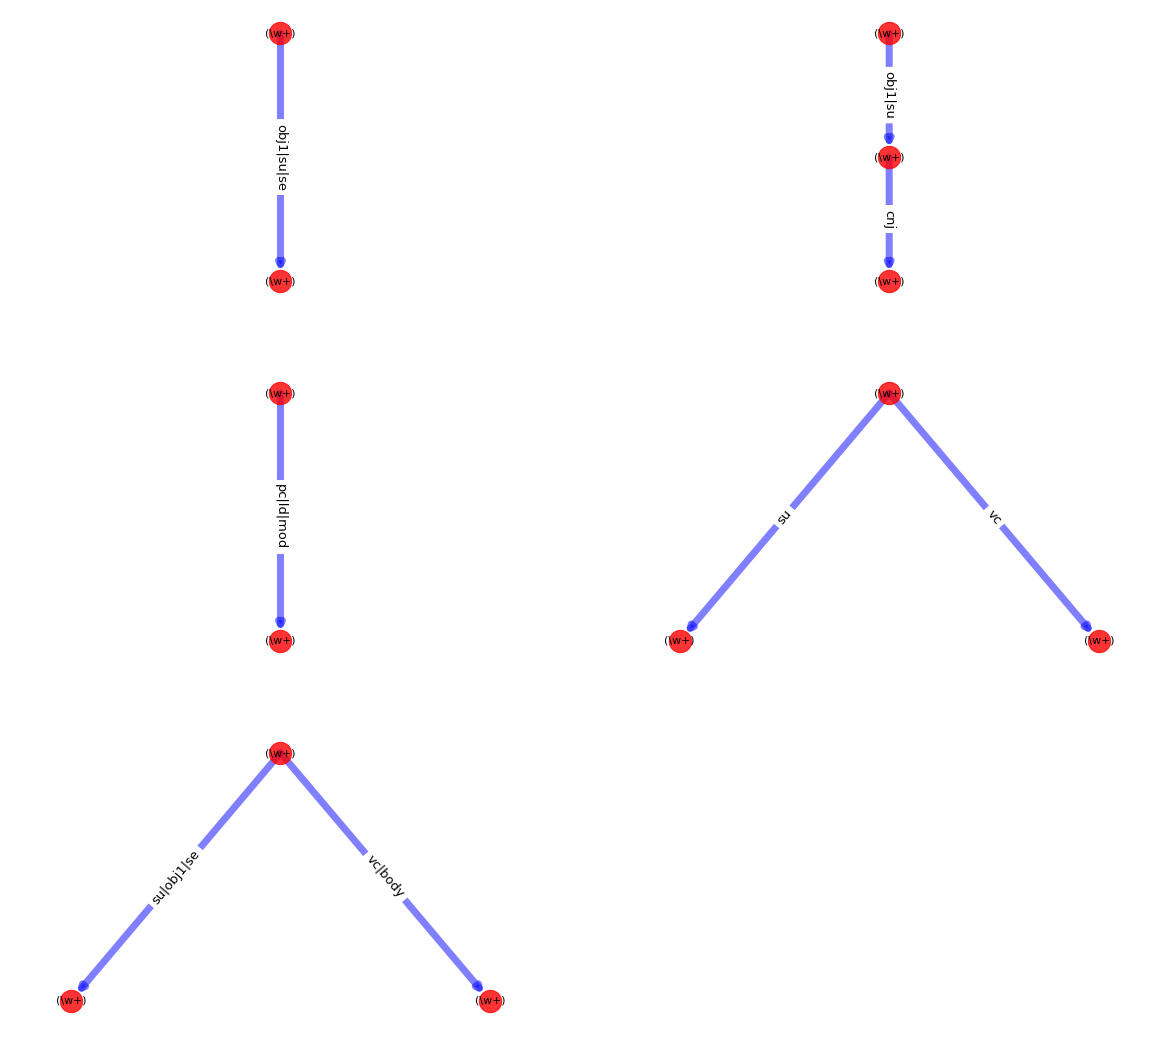

In [18]:
# The objects returned by loadMacro can be plotted:
plotPatterns(rel_macros[0][1])

In [19]:
reldata = createRel(query, settings, rel_macros, type_name = type_name,
              fnames = fnameSample, tokenlist = tokenlist, foc_filter = foc.get_item_list())
reldata.to_csv(f"{output_path}/registers/{type_name}.rel-models.tsv", sep = "\t", index_label = "_model")

Building dependency features...



Building matrix...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.LEMMAREL1.tcmx.bool.pac
Building dependency features...



Building matrix...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.LEMMAREL2.tcmx.bool.pac


In [20]:
# # 6. On a loop per item, row create Path ================================
# for type_name, query_list in only_adjs:
#     query = full.subvocab(query_list)
#     reldata = createRel(query, settings, rel_macros, type_name = type_name,
#                         fnames = fnameSample, tokenlist = adjs, foc_filter = foc.get_item_list())
    
#     # 7. Most probably, store register ================================
#     models_fname = f"{output_path}/registers/{type_name}.rel-models.tsv"
#     reldata.to_csv(models_fname, sep="\t", index_label = '_model')

### 3.3 Lemmapath

Like LEMMAREL, the LEMMAPATH models need 'separator-line-machine' to be properly set and the templates to be loaded.
Unlike LEMMAREL, the templates are not cumulative: LEMMAPATH1 models only cover those with one step between target and context word, while LEMMAPATH2 covers those with two steps. We *could* make them cumulative, but this setup allows us to give them different weights in PATHweight models.

In [21]:
graphml_name = "LEMMAPATH"
templates_dir = f"{mydir}/templates"
path_templates = [loadMacro(templates_dir, graphml_name, f"LEMMAPATH{i}") for i in [1, 2, 3]]
path_macros = [
    # First group includes templates with one and two steps, no weight
    ("LEMMAPATH2", [path_templates[0], path_templates[1]], None),
    # Second group includes templates with up to three steps, no weight
    ("LEMMAPATH3", [path_templates[0], path_templates[1], path_templates[2]], None),
    # Third group includes templates with up to three steps, with weight
    ("LEMMAPATHweight", [path_templates[0], path_templates[1], path_templates[2]], [1, 0.6, 0.3])
]
settings['separator-line-machine'] = "^</sentence>$"

In [22]:
pathdata = createPath(query, settings, path_macros, type_name = type_name,
          fnames = fnameSample, tokenlist = tokenlist, foc_filter = foc.get_item_list())
pathdata.to_csv(f"{output_path}/registers/{type_name}.path-models.tsv", sep = "\t", index_label = "_model")

Building dependency features...



Building matrix...
Building dependency features...



Building matrix...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.LEMMAPATH2.tcmx.bool.pac
Building dependency features...



Building matrix...
Building dependency features...



Building matrix...
Building dependency features...



Building matrix...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.LEMMAPATH3.tcmx.bool.pac
Building dependency features...



Building matrix...
Building dependency features...



Building matrix...
Building dependency features...



Building matrix...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy//destroy.LEMMAPATHweight.tcmx.bool.pac


In [23]:
# # 8. On a loop per item, row create Path ================================
# for type_name, query_list in only_adjs:
#     query = full.subvocab(query_list)
#     pathdata = createPath(query, settings, path_macros, type_name = type_name,
#           fnames = fnameSample, tokenlist = tokenlist, foc_filter = foc.get_item_list())
    
#     # 9. Most probably, store register ================================
#     models_fname = f"{output_path}/registers/{type_name}.path-models.tsv"
#     pathdata.to_csv(models_fname, sep="\t", index_label = '_model')

## 4 Weight or booleanize

Once we have our boolean token-by-feature matrices, we can start combining them with type-level matrices: first to weight them and then to obtain second-order features. These functions will require us to specify the directory where we store our token matrices (in case we want different directories).

In [24]:
token_dir = f"{output_path}/tokens/{type_name}"

### 4.1. Create/load collocation matrix
First of all, we need to have a collocation matrix. The following function checks if the given filename exists and, if it doesn't, it creates the matrix from scratch.

In [25]:
coldir = "/home/projects/semmetrix/NephoSem/input-data/frequency-matrices/QLVLNewsCorpus/"
freq_fname_CW4 = f"{coldir}/QLVLNews.fullcorpus_CW4.wcmx.freq.pac" # window size of 4

In [26]:
#settings['left-span'] = 4
#settings['right-span = 4']
freqMTX_CW4 = loadColloc(freq_fname_CW4, settings)
freqMTX_CW4

[4614267, 4614267]             !!!!!!!!!!!!!!!!!!!!!!!!!/num  !!!!!!!!!!!!!!!!!/num  !!!!!!!!!!!!!!!!/num  !!!!!!!!!!!!!!/num  !!!!!!!!!!!!!/name  !!!!!!!!!!!!!/num  !!!!!!!!!!!!/num  ...
!!!!!!!!!!!!!!!!!!!!!!!!!/num  NaN                            NaN                    NaN                   NaN                 NaN                 NaN                NaN               ...
!!!!!!!!!!!!!!!!!/num          NaN                            NaN                    NaN                   NaN                 NaN                 NaN                NaN               ...
!!!!!!!!!!!!!!!!/num           NaN                            NaN                    NaN                   NaN                 NaN                 NaN                NaN               ...
!!!!!!!!!!!!!!/num             NaN                            NaN                    NaN                   NaN                 NaN                 NaN                NaN               ...
!!!!!!!!!!!!!/name             NaN                          

In [27]:
freq_fname_CW10 = f"{coldir}/QLVLNews.fullcorpus_CW10.wcmx.freq.pac" # window size of 4
#settings['left-span'] = 10
#settings['right-span = 10']
freqMTX_CW10 = loadColloc(freq_fname_CW10, settings)

### 4.2 Register PPMI values

The function below subsets collocation matrices and calculates PMI values based on collocation matrices and frequencies based on vocabularies, to register the information in a dataframe. It returns a specific PPMI dataframe to use for weighting.

In [28]:
ppmi = targetPPMI(query.get_item_list(),
           vocabs = {"freq" : full},
          collocs = {"4" : freqMTX_CW4, "10" : freqMTX_CW10},
          type_name = type_name, output_dir = f"{github_dir}/{type_name}/",
          main_matrix = "4")
ppmi # it returns the PPMI values based on collocs["4"]



************************************
function    = compute_association
  time      = 0.1711 sec
************************************





************************************
function    = compute_association
  time      = 0.2749 sec
************************************



[2, 14453]      !!!/punct  "/punct     '/punct     '40/noun  '44/noun   '67/name   '68_generatie/noun  ...
verniel/verb    NaN        NaN         NaN         4.903999  4.3824615  NaN        7.2866263           ...
vernietig/verb  2.2368245  0.20710099  0.25722486  NaN       NaN        4.8763175  NaN                 ...

In [29]:
import pandas as pd
with open(f"{github_dir}/{type_name}/{type_name}.ppmi.tsv", "r") as f:
    pmidf = pd.read_csv(f, sep = "\t", index_col = "cw")
pmidf

,pmi_4_verniel/verb,pmi_4_vernietig/verb,raw_4_verniel/verb,raw_4_vernietig/verb,pmi_10_verniel/verb,pmi_10_vernietig/verb,raw_10_verniel/verb,raw_10_vernietig/verb,freq
cw,,,,,,,,,
!!!/punct,NaN,2.236824,NaN,1.0,NaN,1.331356,NaN,1.0,592
!/name,-0.776889,-0.166773,1.0,3.0,-0.575533,-1.070589,3.0,3.0,19257
!/punct,-1.148367,-0.027426,5.0,25.0,-1.170905,-0.366678,12.0,44.0,142029
!?/name,NaN,NaN,NaN,NaN,3.903481,NaN,1.0,NaN,73
"""/punct",-0.416885,0.207101,358.0,1089.0,-0.523912,0.023079,794.0,2251.0,4844510
&/name,-1.789608,-1.179493,1.0,3.0,-2.685440,-1.571058,1.0,5.0,52896
&Wardwell/name,NaN,NaN,NaN,NaN,NaN,6.980771,NaN,1.0,2
'/punct,-0.873048,0.257225,128.0,646.0,-0.837387,0.136009,327.0,1420.0,2720890
'14-'18/num,NaN,NaN,NaN,NaN,NaN,3.126377,NaN,1.0,96


In [30]:
# # 10. On a loop per item, row weight models ================================
# for type_name, query_list in only_adjs:
#     ppmi = targetPPMI(query_list,
#            vocabs = {"freq" : full},
#                       collocs = {"4" : freqMTX_CW4, "10" : freqMTX_CW10},
#                       type_name = type_name, output_dir = f"{output_path}/registers/",
#                       main_matrix = "4")

### 4.3 Implement weighting on selection

This step is performed on all the matrices created up to this moment. A useful thing to do first is to combine all the first-order register information we have from the different kinds of models.

In [31]:
registers = loadFocRegisters(f"{output_path}/registers", type_name)

Once we have the registers, we can also set the values for our `PPMI` setting with the `weighting` dictionary. A value `None` indicates that no weighting is applied, while matrices as values (a boolean version for selection instead of weighting, for example) are used to weight the tokens.

In [32]:
from semasioFlow.utils import booleanize
weighting = {
    "no" : None,
    "selection" : booleanize(ppmi, include_negative=False),
    "weight" : ppmi
}

In [33]:
x = "weight"

In [34]:
weighting[x] if weighting[x] else "no matrix"

[2, 14453]      !!!/punct  "/punct     '/punct     '40/noun  '44/noun   '67/name   '68_generatie/noun  ...
verniel/verb    NaN        NaN         NaN         4.903999  4.3824615  NaN        7.2866263           ...
vernietig/verb  2.2368245  0.20710099  0.25722486  NaN       NaN        4.8763175  NaN                 ...

In [35]:
weight_data = weightTokens(token_dir, weighting, registers)


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIno.tcmx.weight.pac

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIselection.tcmx.weight.pac

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIweight.tcmx.weight.pac

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIno.tcmx.weight.pac

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIselection.tcmx.weight.pac

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIweight.tcmx.weight.pac

Saving matrix...
Stored

In [36]:
# new model register
weight_data["model_register"]
# weight_data["model_register"].to_csv(f"{output_path}/register/destroy.focmodels.tsv", sep = '\t', index_label = "_model")

,LEMMAPATH,LEMMAREL,bound,foc_base,foc_context_words,foc_pmi,foc_pos,foc_win,tokens
destroy.LEMMAPATH2.PPMIno,LEMMAPATH2,NaN,NaN,LEMMAPATH,172,no,NaN,NaN,60
destroy.LEMMAPATH2.PPMIselection,LEMMAPATH2,NaN,NaN,LEMMAPATH,132,selection,NaN,NaN,60
destroy.LEMMAPATH2.PPMIweight,LEMMAPATH2,NaN,NaN,LEMMAPATH,132,weight,NaN,NaN,60
destroy.LEMMAPATH3.PPMIno,LEMMAPATH3,NaN,NaN,LEMMAPATH,250,no,NaN,NaN,58
destroy.LEMMAPATH3.PPMIselection,LEMMAPATH3,NaN,NaN,LEMMAPATH,184,selection,NaN,NaN,58
destroy.LEMMAPATH3.PPMIweight,LEMMAPATH3,NaN,NaN,LEMMAPATH,184,weight,NaN,NaN,58
destroy.LEMMAPATHweight.PPMIno,LEMMAPATHweight,NaN,NaN,LEMMAPATH,250,no,NaN,NaN,58
destroy.LEMMAPATHweight.PPMIselection,LEMMAPATHweight,NaN,NaN,LEMMAPATH,184,selection,NaN,NaN,58
destroy.LEMMAPATHweight.PPMIweight,LEMMAPATHweight,NaN,NaN,LEMMAPATH,184,weight,NaN,NaN,58
destroy.LEMMAREL1.PPMIno,NaN,LEMMAREL1,NaN,LEMMAREL,97,no,NaN,NaN,55


In [37]:
# token_level register
weight_data["token_register"]
github_type = f"{github_dir}/{type_name}"
if not os.path.exists(github_type):
    os.makedirs(github_type)
    
weight_data["token_register"].to_csv(f"{github_type}/{type_name}.variables.tsv", sep = '\t', index_label = "_id")

In [38]:
# 11. On a loop per item, row weight models ================================
# for type_name in adj_lemmas:
#     foc_registers = loadFocRegisters(f"{output_path}/registers", type_name)
#     weight_data = weightTokens(token_dir, weighting, registers)
#     weight_data["model_register"].to_csv(f"{output_path}/register/{type_name}.focmodels.tsv",
#                                          index_label = "_model")
#     github_type = f"{github_dir}/{type_name}"
#     if not os.path.exists(github_type):
#         os.makedirs(github_type)
#     weight_data["token_register"].to_csv(f"{github_type}/{type_name}.focmodels.tsv",
#                                          index_label = "_model")

### 5 Second-order dimensions

The final step to obtain our token-level vectors is to multiply the token-foc matrices for type-level matrices to obtain second-order vectors. We will loop over the models in the index of `weight_data["model_register"]` and over second-order parameter settings to filter `freqMTX_CW4` and obtain different models.

In [39]:
soc_pos = {
    "all" : foc,
    "nav" : soc
}
lengths = ["FOC", 5000] # a number will take the most frequent; something else will take the FOC items

In [40]:
socdata = createSoc(token_dir,
                    registers = weight_data['model_register'],
                   soc_pos = soc_pos, lengths = lengths,
                   socMTX = freqMTX_CW4, store_focdists = f"{output_path}/cws/{type_name}/")



************************************
function    = compute_association
  time      = 0.1729 sec
************************************


************************************
function    = compute_distance
  time      = 0.001491 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.117 sec
************************************


************************************
function    = compute_distance
  time      = 0.007475 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1125 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008636 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.86 sec
************************************


************************************
function    = compute_distance
  time      = 0.007209 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1184 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007915 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.499 sec
************************************


************************************
function    = compute_distance
  time      = 0.008267 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.0984 sec
************************************


************************************
function    = compute_distance
  time      = 0.000854 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.38 sec
************************************


************************************
function    = compute_distance
  time      = 0.005088 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1145 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007269 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.515 sec
************************************


************************************
function    = compute_distance
  time      = 0.005095 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09723 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008435 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.417 sec
************************************


************************************
function    = compute_distance
  time      = 0.005049 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2302 sec
************************************


************************************
function    = compute_distance
  time      = 0.001689 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.878 sec
************************************


************************************
function    = compute_distance
  time      = 0.01209 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1561 sec
************************************


************************************
function    = compute_distance
  time      = 0.001496 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.627 sec
************************************


************************************
function    = compute_distance
  time      = 0.01213 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1547 sec
************************************


************************************
function    = compute_distance
  time      = 0.001198 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.038 sec
************************************


************************************
function    = compute_distance
  time      = 0.009572 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1352 sec
************************************


************************************
function    = compute_distance
  time      = 0.001088 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.937 sec
************************************


************************************
function    = compute_distance
  time      = 0.007526 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1575 sec
************************************


************************************
function    = compute_distance
  time      = 0.001067 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.059 sec
************************************


************************************
function    = compute_distance
  time      = 0.007737 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1219 sec
************************************


************************************
function    = compute_distance
  time      = 0.001002 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.923 sec
************************************


************************************
function    = compute_distance
  time      = 0.007514 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH3.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2264 sec
************************************


************************************
function    = compute_distance
  time      = 0.001769 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.836 sec
************************************


************************************
function    = compute_distance
  time      = 0.01203 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1581 sec
************************************


************************************
function    = compute_distance
  time      = 0.001433 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.629 sec
************************************


************************************
function    = compute_distance
  time      = 0.01201 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.155 sec
************************************


************************************
function    = compute_distance
  time      = 0.001114 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.021 sec
************************************


************************************
function    = compute_distance
  time      = 0.007819 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1193 sec
************************************


************************************
function    = compute_distance
  time      = 0.000993 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.874 sec
************************************


************************************
function    = compute_distance
  time      = 0.007537 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1568 sec
************************************


************************************
function    = compute_distance
  time      = 0.001076 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.117 sec
************************************


************************************
function    = compute_distance
  time      = 0.00793 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1243 sec
************************************


************************************
function    = compute_distance
  time      = 0.001037 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.905 sec
************************************


************************************
function    = compute_distance
  time      = 0.00774 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09658 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008082 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.125 sec
************************************


************************************
function    = compute_distance
  time      = 0.005366 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09702 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008752 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.049 sec
************************************


************************************
function    = compute_distance
  time      = 0.00369 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1143 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007906 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.7935 sec
************************************


************************************
function    = compute_distance
  time      = 0.002531 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.08076 sec
************************************


************************************
function    = compute_distance
  time      = 0.001036 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.7122 sec
************************************


************************************
function    = compute_distance
  time      = 0.002427 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.103 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008297 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.7789 sec
************************************


************************************
function    = compute_distance
  time      = 0.002471 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.08079 sec
************************************


************************************
function    = compute_distance
  time      = 0.000875 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.7331 sec
************************************


************************************
function    = compute_distance
  time      = 0.002471 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL1.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1129 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008404 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.464 sec
************************************


************************************
function    = compute_distance
  time      = 0.005347 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09652 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007143 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.345 sec
************************************


************************************
function    = compute_distance
  time      = 0.004726 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.0968 sec
************************************


************************************
function    = compute_distance
  time      = 0.0006914 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.083 sec
************************************


************************************
function    = compute_distance
  time      = 0.003463 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.08875 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007186 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.9848 sec
************************************


************************************
function    = compute_distance
  time      = 0.003653 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.0959 sec
************************************


************************************
function    = compute_distance
  time      = 0.0006659 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.077 sec
************************************


************************************
function    = compute_distance
  time      = 0.003438 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.0875 sec
************************************


************************************
function    = compute_distance
  time      = 0.00067 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.9803 sec
************************************


************************************
function    = compute_distance
  time      = 0.003713 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.3931 sec
************************************


************************************
function    = compute_distance
  time      = 0.003366 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 3.92 sec
************************************


************************************
function    = compute_distance
  time      = 0.02222 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2328 sec
************************************


************************************
function    = compute_distance
  time      = 0.002342 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 3.701 sec
************************************


************************************
function    = compute_distance
  time      = 0.0222 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2178 sec
************************************


************************************
function    = compute_distance
  time      = 0.001664 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.713 sec
************************************


************************************
function    = compute_distance
  time      = 0.01472 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1877 sec
************************************


************************************
function    = compute_distance
  time      = 0.001389 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.423 sec
************************************


************************************
function    = compute_distance
  time      = 0.01226 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2127 sec
************************************


************************************
function    = compute_distance
  time      = 0.001605 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.734 sec
************************************


************************************
function    = compute_distance
  time      = 0.01243 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1535 sec
************************************


************************************
function    = compute_distance
  time      = 0.001403 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.49 sec
************************************


************************************
function    = compute_distance
  time      = 0.01213 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10all.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2191 sec
************************************


************************************
function    = compute_distance
  time      = 0.001604 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.789 sec
************************************


************************************
function    = compute_distance
  time      = 0.0119 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1829 sec
************************************


************************************
function    = compute_distance
  time      = 0.001472 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.43 sec
************************************


************************************
function    = compute_distance
  time      = 0.01168 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1458 sec
************************************


************************************
function    = compute_distance
  time      = 0.001024 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.917 sec
************************************


************************************
function    = compute_distance
  time      = 0.007821 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.132 sec
************************************


************************************
function    = compute_distance
  time      = 0.0009747 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.753 sec
************************************


************************************
function    = compute_distance
  time      = 0.007611 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1464 sec
************************************


************************************
function    = compute_distance
  time      = 0.001046 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.968 sec
************************************


************************************
function    = compute_distance
  time      = 0.007946 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1322 sec
************************************


************************************
function    = compute_distance
  time      = 0.0009971 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.836 sec
************************************


************************************
function    = compute_distance
  time      = 0.008718 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1714 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008237 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.803 sec
************************************


************************************
function    = compute_distance
  time      = 0.005889 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1052 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007412 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.67 sec
************************************


************************************
function    = compute_distance
  time      = 0.006024 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1084 sec
************************************


************************************
function    = compute_distance
  time      = 0.000772 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.365 sec
************************************


************************************
function    = compute_distance
  time      = 0.004593 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09364 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007091 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.261 sec
************************************


************************************
function    = compute_distance
  time      = 0.004466 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1097 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007455 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.41 sec
************************************


************************************
function    = compute_distance
  time      = 0.004712 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09539 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007162 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.268 sec
************************************


************************************
function    = compute_distance
  time      = 0.004472 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3all.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.0997 sec
************************************


************************************
function    = compute_distance
  time      = 0.000694 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.166 sec
************************************


************************************
function    = compute_distance
  time      = 0.003595 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09527 sec
************************************


************************************
function    = compute_distance
  time      = 0.000694 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.084 sec
************************************


************************************
function    = compute_distance
  time      = 0.003632 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09439 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008645 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.018 sec
************************************


************************************
function    = compute_distance
  time      = 0.003407 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.08937 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008781 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.905 sec
************************************


************************************
function    = compute_distance
  time      = 0.003272 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09149 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007188 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.019 sec
************************************


************************************
function    = compute_distance
  time      = 0.00324 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.08963 sec
************************************


************************************
function    = compute_distance
  time      = 0.000561 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.9081 sec
************************************


************************************
function    = compute_distance
  time      = 0.003158 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2126 sec
************************************


************************************
function    = compute_distance
  time      = 0.001478 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.691 sec
************************************


************************************
function    = compute_distance
  time      = 0.01108 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.147 sec
************************************


************************************
function    = compute_distance
  time      = 0.001284 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.504 sec
************************************


************************************
function    = compute_distance
  time      = 0.01163 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1863 sec
************************************


************************************
function    = compute_distance
  time      = 0.001029 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.92 sec
************************************


************************************
function    = compute_distance
  time      = 0.007219 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1146 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008993 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.756 sec
************************************


************************************
function    = compute_distance
  time      = 0.006953 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1433 sec
************************************


************************************
function    = compute_distance
  time      = 0.000978 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.963 sec
************************************


************************************
function    = compute_distance
  time      = 0.007147 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1139 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008738 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.765 sec
************************************


************************************
function    = compute_distance
  time      = 0.006868 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1357 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008879 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.765 sec
************************************


************************************
function    = compute_distance
  time      = 0.006382 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1201 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008733 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.652 sec
************************************


************************************
function    = compute_distance
  time      = 0.006263 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1095 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007095 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.394 sec
************************************


************************************
function    = compute_distance
  time      = 0.004869 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1022 sec
************************************


************************************
function    = compute_distance
  time      = 0.0006917 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.26 sec
************************************


************************************
function    = compute_distance
  time      = 0.004791 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1141 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007432 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.397 sec
************************************


************************************
function    = compute_distance
  time      = 0.004876 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1023 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007215 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.293 sec
************************************


************************************
function    = compute_distance
  time      = 0.004869 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5lex.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.629 sec
************************************


************************************
function    = compute_distance
  time      = 0.005537 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 5.463 sec
************************************


************************************
function    = compute_distance
  time      = 0.04231 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.4048 sec
************************************


************************************
function    = compute_distance
  time      = 0.004593 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 5.001 sec
************************************


************************************
function    = compute_distance
  time      = 0.03855 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.3183 sec
************************************


************************************
function    = compute_distance
  time      = 0.002484 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 3.58 sec
************************************


************************************
function    = compute_distance
  time      = 0.02118 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2047 sec
************************************


************************************
function    = compute_distance
  time      = 0.002087 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 3.397 sec
************************************


************************************
function    = compute_distance
  time      = 0.02062 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.3358 sec
************************************


************************************
function    = compute_distance
  time      = 0.002592 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 3.698 sec
************************************


************************************
function    = compute_distance
  time      = 0.02096 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2064 sec
************************************


************************************
function    = compute_distance
  time      = 0.002146 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 3.137 sec
************************************


************************************
function    = compute_distance
  time      = 0.01999 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.3335 sec
************************************


************************************
function    = compute_distance
  time      = 0.00271 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 3.691 sec
************************************


************************************
function    = compute_distance
  time      = 0.02261 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.3234 sec
************************************


************************************
function    = compute_distance
  time      = 0.002644 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 3.387 sec
************************************


************************************
function    = compute_distance
  time      = 0.01923 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1957 sec
************************************


************************************
function    = compute_distance
  time      = 0.001496 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.552 sec
************************************


************************************
function    = compute_distance
  time      = 0.0109 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1729 sec
************************************


************************************
function    = compute_distance
  time      = 0.001354 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.302 sec
************************************


************************************
function    = compute_distance
  time      = 0.01079 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2031 sec
************************************


************************************
function    = compute_distance
  time      = 0.001546 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.617 sec
************************************


************************************
function    = compute_distance
  time      = 0.02885 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2135 sec
************************************


************************************
function    = compute_distance
  time      = 0.001433 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.262 sec
************************************


************************************
function    = compute_distance
  time      = 0.0127 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10lex.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1603 sec
************************************


************************************
function    = compute_distance
  time      = 0.001012 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.163 sec
************************************


************************************
function    = compute_distance
  time      = 0.007782 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1163 sec
************************************


************************************
function    = compute_distance
  time      = 0.000947 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.007 sec
************************************


************************************
function    = compute_distance
  time      = 0.007876 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1654 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008163 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.677 sec
************************************


************************************
function    = compute_distance
  time      = 0.005461 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1002 sec
************************************


************************************
function    = compute_distance
  time      = 0.0009284 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.599 sec
************************************


************************************
function    = compute_distance
  time      = 0.005555 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1251 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007937 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.671 sec
************************************


************************************
function    = compute_distance
  time      = 0.005523 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09961 sec
************************************


************************************
function    = compute_distance
  time      = 0.0009134 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.525 sec
************************************


************************************
function    = compute_distance
  time      = 0.005466 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1098 sec
************************************


************************************
function    = compute_distance
  time      = 0.0007041 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.35 sec
************************************


************************************
function    = compute_distance
  time      = 0.004709 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1014 sec
************************************


************************************
function    = compute_distance
  time      = 0.0006781 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.241 sec
************************************


************************************
function    = compute_distance
  time      = 0.00497 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1134 sec
************************************


************************************
function    = compute_distance
  time      = 0.0006349 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.063 sec
************************************


************************************
function    = compute_distance
  time      = 0.00326 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1141 sec
************************************


************************************
function    = compute_distance
  time      = 0.0006046 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.9726 sec
************************************


************************************
function    = compute_distance
  time      = 0.003488 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1119 sec
************************************


************************************
function    = compute_distance
  time      = 0.0006382 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.096 sec
************************************


************************************
function    = compute_distance
  time      = 0.003359 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.09223 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008216 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.9863 sec
************************************


************************************
function    = compute_distance
  time      = 0.00344 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3lex.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2746 sec
************************************


************************************
function    = compute_distance
  time      = 0.001973 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 3.252 sec
************************************


************************************
function    = compute_distance
  time      = 0.01631 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1874 sec
************************************


************************************
function    = compute_distance
  time      = 0.00177 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.999 sec
************************************


************************************
function    = compute_distance
  time      = 0.01609 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.2204 sec
************************************


************************************
function    = compute_distance
  time      = 0.001408 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.343 sec
************************************


************************************
function    = compute_distance
  time      = 0.01646 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1349 sec
************************************


************************************
function    = compute_distance
  time      = 0.001114 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.109 sec
************************************


************************************
function    = compute_distance
  time      = 0.01008 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1818 sec
************************************


************************************
function    = compute_distance
  time      = 0.001461 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.308 sec
************************************


************************************
function    = compute_distance
  time      = 0.01162 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1926 sec
************************************


************************************
function    = compute_distance
  time      = 0.001259 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.215 sec
************************************


************************************
function    = compute_distance
  time      = 0.009971 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1643 sec
************************************


************************************
function    = compute_distance
  time      = 0.001181 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIno.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.215 sec
************************************


************************************
function    = compute_distance
  time      = 0.008306 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIno.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1484 sec
************************************


************************************
function    = compute_distance
  time      = 0.001104 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIno.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 2.005 sec
************************************


************************************
function    = compute_distance
  time      = 0.01078 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIno.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1254 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008755 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIselection.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.741 sec
************************************


************************************
function    = compute_distance
  time      = 0.006452 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIselection.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1196 sec
************************************


************************************
function    = compute_distance
  time      = 0.000947 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIselection.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.563 sec
************************************


************************************
function    = compute_distance
  time      = 0.006557 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIselection.LENGTH5000.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1487 sec
************************************


************************************
function    = compute_distance
  time      = 0.0009754 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIweight.LENGTHFOC.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.718 sec
************************************


************************************
function    = compute_distance
  time      = 0.006962 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIweight.LENGTH5000.SOCPOSall.tcmx.soc.pac




************************************
function    = compute_association
  time      = 0.1438 sec
************************************


************************************
function    = compute_distance
  time      = 0.0008528 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIweight.LENGTHFOC.SOCPOSnav.tcmx.soc.pac




************************************
function    = compute_association
  time      = 1.565 sec
************************************


************************************
function    = compute_distance
  time      = 0.006367 sec
************************************

  Operation: addition 'token-feature weight matrix' X 'socc matrix'...

Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5lex.PPMIweight.LENGTH5000.SOCPOSnav.tcmx.soc.pac


In [41]:
socdata

,LEMMAPATH,LEMMAREL,bound,foc_base,foc_context_words,foc_pmi,foc_pos,foc_win,soc_length,soc_pos,tokens
destroy.LEMMAPATH2.PPMIno.LENGTH5000.SOCPOSall,LEMMAPATH2,NaN,NaN,LEMMAPATH,172,no,NaN,NaN,5000,all,60
destroy.LEMMAPATH2.PPMIno.LENGTH5000.SOCPOSnav,LEMMAPATH2,NaN,NaN,LEMMAPATH,172,no,NaN,NaN,5000,nav,60
destroy.LEMMAPATH2.PPMIno.LENGTHFOC.SOCPOSall,LEMMAPATH2,NaN,NaN,LEMMAPATH,172,no,NaN,NaN,FOC,all,60
destroy.LEMMAPATH2.PPMIno.LENGTHFOC.SOCPOSnav,LEMMAPATH2,NaN,NaN,LEMMAPATH,172,no,NaN,NaN,FOC,nav,60
destroy.LEMMAPATH2.PPMIselection.LENGTH5000.SOCPOSall,LEMMAPATH2,NaN,NaN,LEMMAPATH,132,selection,NaN,NaN,5000,all,60
destroy.LEMMAPATH2.PPMIselection.LENGTH5000.SOCPOSnav,LEMMAPATH2,NaN,NaN,LEMMAPATH,132,selection,NaN,NaN,5000,nav,60
destroy.LEMMAPATH2.PPMIselection.LENGTHFOC.SOCPOSall,LEMMAPATH2,NaN,NaN,LEMMAPATH,132,selection,NaN,NaN,FOC,all,60
destroy.LEMMAPATH2.PPMIselection.LENGTHFOC.SOCPOSnav,LEMMAPATH2,NaN,NaN,LEMMAPATH,132,selection,NaN,NaN,FOC,nav,60
destroy.LEMMAPATH2.PPMIweight.LENGTH5000.SOCPOSall,LEMMAPATH2,NaN,NaN,LEMMAPATH,132,weight,NaN,NaN,5000,all,60
destroy.LEMMAPATH2.PPMIweight.LENGTH5000.SOCPOSnav,LEMMAPATH2,NaN,NaN,LEMMAPATH,132,weight,NaN,NaN,5000,nav,60


In [42]:
socdata.to_csv(f"{github_type}/{type_name}.models.tsv", sep = "\t", index_label="_model")

In [43]:
# # 12. On a loop per item, create Soc models ================================
# for type_name in adj_lemmas:
#     registers = pd.read_csv(f"{output_path}/register/{type_name}.focmodels.tsv",
#                            sep = "\t", index_col = "_model")
#     socdata = createSoc(token_dir, registers = registers,
#                    soc_pos = soc_pos, lengths = lengths,
#                    socMTX = freqMTX_CW4, store_focdists = f"{output_path}/cws/{type_name}/")
#     socdata.to_csv(f"{github_type}/{type_name}.models.tsv", sep = "\t", index_label="_model")

### 6 Cosine distances
Once we have all the token-level vectors, as well as our registers,
we can quickly compute and store their cosine distances.

In [44]:
from qlvl import TypeTokenMatrix
from qlvl.specutils.mxcalc import compute_distance

input_suffix = ".tcmx.soc.pac" #token by context matrix
output_suffix = ".ttmx.dist.pac" # token by token matrix
for modelname in socdata.index:
    input_name = f"{token_dir}/{modelname}{input_suffix}"
    output_name = f"{token_dir}/{modelname}{output_suffix}"
    compute_distance(TypeTokenMatrix.load(input_name)).save(output_name)
    


************************************
function    = compute_distance
  time      = 0.004143 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIno.LENGTH5000.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.003516 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIno.LENGTH5000.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.000495 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATH2.PPMIno.LENGTHFOC.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  tim

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIno.LENGTHFOC.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.0004344 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIno.LENGTHFOC.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.003389 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAPATHweight.PPMIselection.LENGTH5000.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.003386 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_w


************************************
function    = compute_distance
  time      = 0.003114 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIselection.LENGTH5000.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.000397 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIselection.LENGTHFOC.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.0003636 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.LEMMAREL2.PPMIselection.LENGTHFOC.SOCPOSnav.ttmx.dist.pac

************************************
function    = comp

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIselection.LENGTHFOC.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.003235 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIweight.LENGTH5000.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.003181 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound10-10lex.PPMIweight.LENGTH5000.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.0004592 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/marian

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIweight.LENGTHFOC.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.0003791 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound3-3lex.PPMIweight.LENGTHFOC.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.003356 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.bound5-5all.PPMIno.LENGTH5000.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.003342 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/clean


************************************
function    = compute_distance
  time      = 0.003379 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIno.LENGTH5000.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.0007288 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIno.LENGTHFOC.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.0005741 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound10-10all.PPMIno.LENGTHFOC.SOCPOSnav.ttmx.dist.pac

************************************
function    = comput

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIno.LENGTHFOC.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.003459 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIselection.LENGTH5000.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.003452 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound3-3all.PPMIselection.LENGTH5000.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.000452 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_

Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIselection.LENGTH5000.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.0005312 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIselection.LENGTHFOC.SOCPOSall.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.0004342 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/mariana_wolken/cleanWorkflow//output//tokens/destroy/destroy.nobound5-5all.PPMIselection.LENGTHFOC.SOCPOSnav.ttmx.dist.pac

************************************
function    = compute_distance
  time      = 0.003565 sec
************************************


Saving matrix...
Stored in file:
  /home/projects/semmetrix/

In [45]:
#13. On a loop per item, compute distances ======================================
# input_suffix = ".tcmx.soc.pac" #token by context matrix
# output_suffix = ".ttmx.dist.pac" # token by token matrix
# for type_name in adj_lemmas:
#     socdata = pd.read_csv(f"{github_type}/{type_name}.models.tsv",
#                          sep = "\t", index_col = "_model")
#     for modelname in socdata.index:
#         input_name = f"{token_dir}/{modelname}{input_suffix}"
#         output_name = f"{token_dir}/{modelname}{output_suffix}"
#         compute_distance(TypeTokenMatrix.load(input_name)).save(output_name)
    

For the rest, we go to R!

The R code is in the processClouds notebook, which uses the [semcloud](https://github.com/montesmariana/semcloud) package. I plan to incorporate small clouds into the package to use for examples and recreate the processClouds notebook as a vignette for the package.

## Bonus: context word detail

In [6]:
from semasioFlow.contextwords import listContextwords

In [7]:
from nephosem import CorpusFormatter

In [8]:
formatter = CorpusFormatter(settings)

In [9]:
formatter.line_machine

re.compile(r'([^\t]+)\t([^\t]+)\t([^\t]+)', re.UNICODE)

In [12]:
formatter.match_line('word\tlemma\tpos').groups()

('word', 'lemma', 'pos')

In [47]:
type_name = "destroy"

In [53]:
cws = listContextwords(type_name, tokenlist, fnameSample, settings, left_win=15, right_win = 15)

100%|██████████| 60/60 [00:00<00:00, 455.16it/s]


In [ ]:
cw_fname = f"{output_path}/registers/{type_name}.cws.detail.tsv"
cws.to_csv(cw_fname, sep = "\t", index_label = "cw_id")
cws

In [ ]:
# # On a loop
# for type_name in all_djs:
#     cws = listContextwords(type_name, tokenlist, fnameSample, settings, left_win=15, right_win = 15)
#     cw_fname = f"{output_path}/registers/{type_name}.cws.detail.tsv"
#     cws.to_csv(cw_fname, sep = "\t", index_label = "cw_id")

From this table, it is relatively straightforward to extract concordances and highlight the context words that match certain filters. Note that by default the left contexts are in reverse order.